# Libraries

In [91]:
import os
# Set the environment variable to avoid the OpenMP error
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from sklearn.model_selection import train_test_split
from darts import TimeSeries
from darts.metrics import mae, rmse
from darts.ad import ForecastingAnomalyModel, NormScorer, WassersteinScorer
from darts.models import TCNModel
from sklearn.preprocessing import RobustScaler
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from torch.optim import Adam, SGD
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
#%% Load Data

train_df = pd.read_csv("D:/ECG5000/ECG5000_TRAIN.txt", delimiter='\s+', header=None)
test_df = pd.read_csv("D:/ECG5000/ECG5000_TEST.txt", delimiter='\s+', header=None)

In [3]:
#%% Combine Data

combined_data = pd.concat([train_df, test_df], ignore_index=True)
combined_data.to_csv('D:/ECG5000/Combined_data.csv', index=False, header=False)
combined_data.head()

0         1         2         3         4         5         6         7    \
0  1.0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1  1.0 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2  1.0 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  1.0  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  1.0  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        8         9    ...       131       132       133       134       135  \
0 -1.818286 -1.250522  ...  0.160348  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  ...  0.560327  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580  ...  1.284825  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884  ...  0.491173  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450  ...  0.966606  1.148884  0.958434  1.059025  1.371682   

        136       137       138       139       140  
0  0.257740  0.228077  0.123431  0.925286  0.193137  
1  0.555784  0.476333  0.773820  1.119621 -1.436250  
2 -0.713683 -0.532197  0.321097  0.904227 -0.421797  
3  0.952074  0.990133  1.086798  1.403011 -0.383564  
4  1.277392  0.960304  0.971020  1.614392  1.421456  

[5 rows x 141 columns]

# Plotting

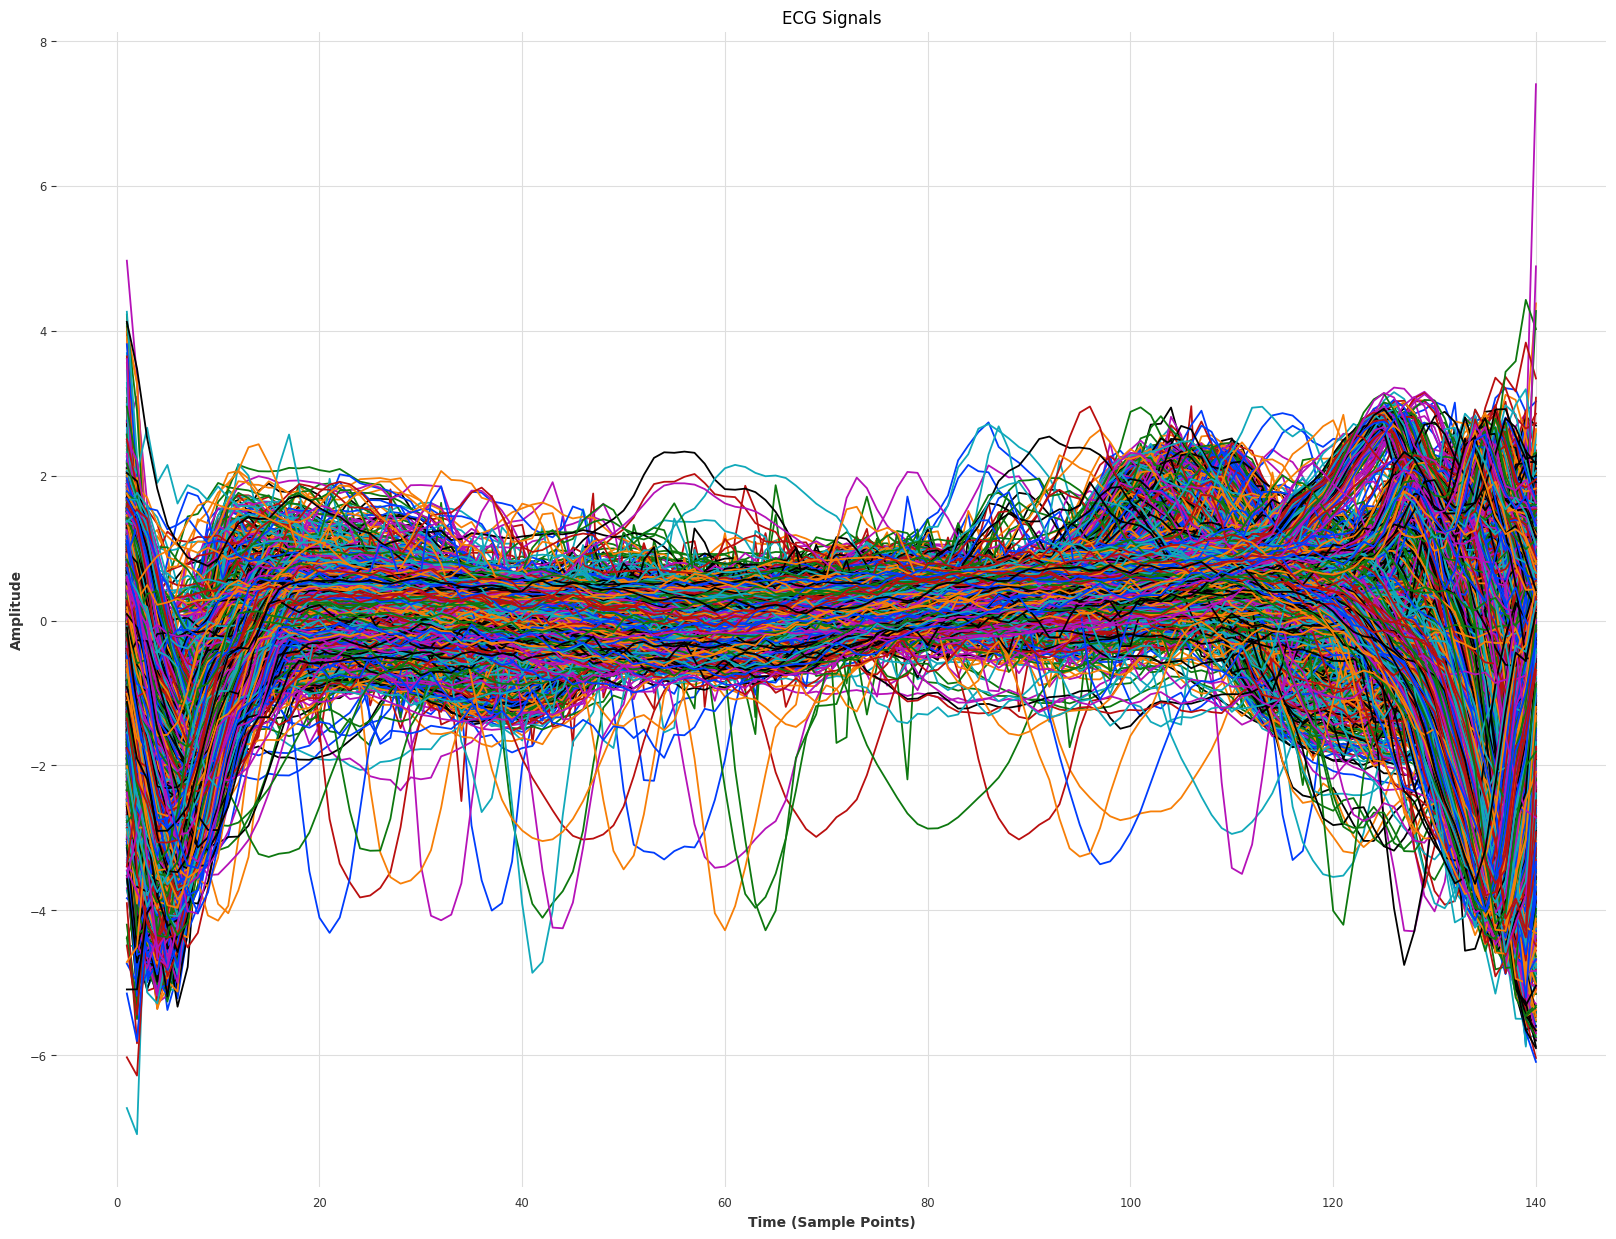

In [4]:
#%% Plot All ECG Signals

ecg_signals = combined_data.iloc[:, 1:]

plt.figure(figsize=(20, 15))
for index, row in ecg_signals.iterrows():
    plt.plot(row, label=f'Signal {index + 1}')
plt.xlabel('Time (Sample Points)')
plt.ylabel('Amplitude')
plt.title('ECG Signals')
plt.show()

In [5]:
#%% Extract and Save Normal Data

normal_data = combined_data[combined_data.iloc[:, 0] == 1.0]
normal_data.to_csv('D:/ECG5000/ecg5000_normal.csv', index=False)
normal_data = pd.read_csv('D:/ECG5000/ecg5000_normal.csv')


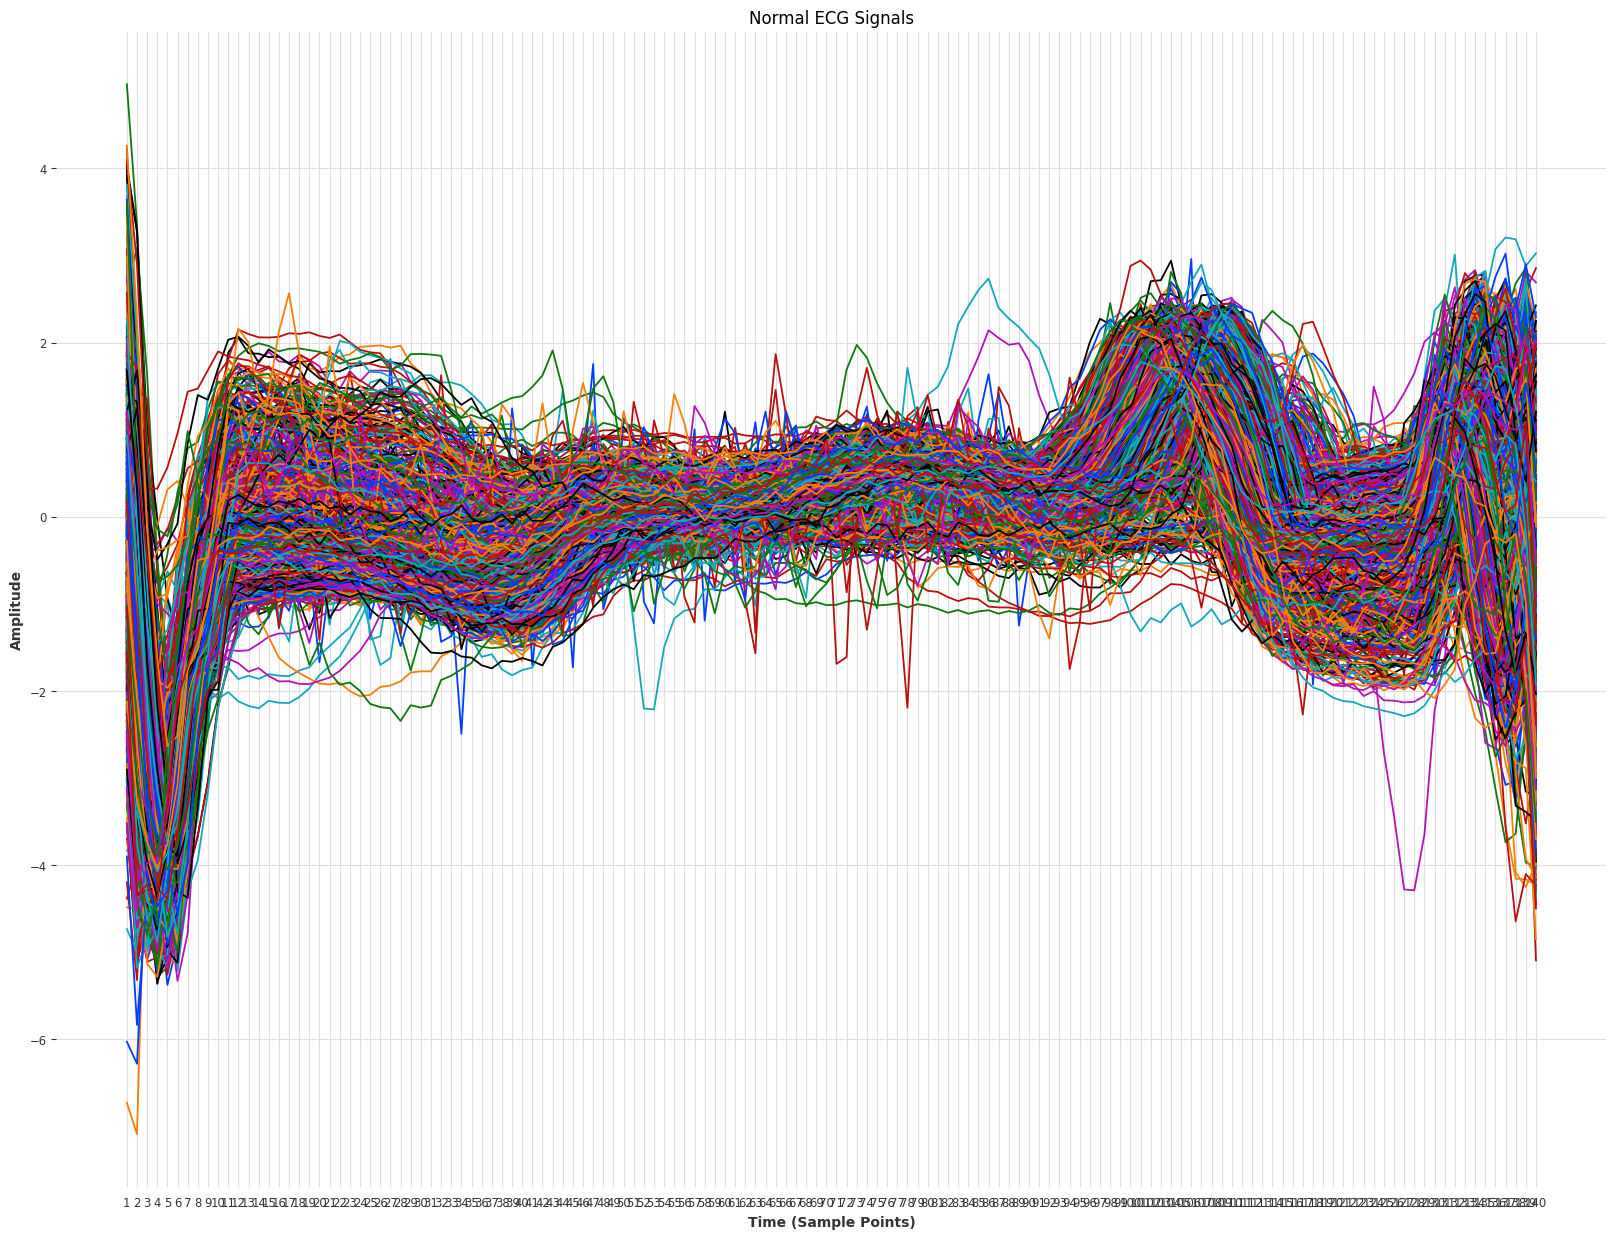

In [6]:
#%% Plot All Normal ECG Signals

ecg_signals = normal_data.iloc[:, 1:]

plt.figure(figsize=(20, 15))
for index, row in ecg_signals.iterrows():
    plt.plot(row, label=f'Signal {index + 1}')
plt.xlabel('Time (Sample Points)')
plt.ylabel('Amplitude')
plt.title('Normal ECG Signals')
plt.show()


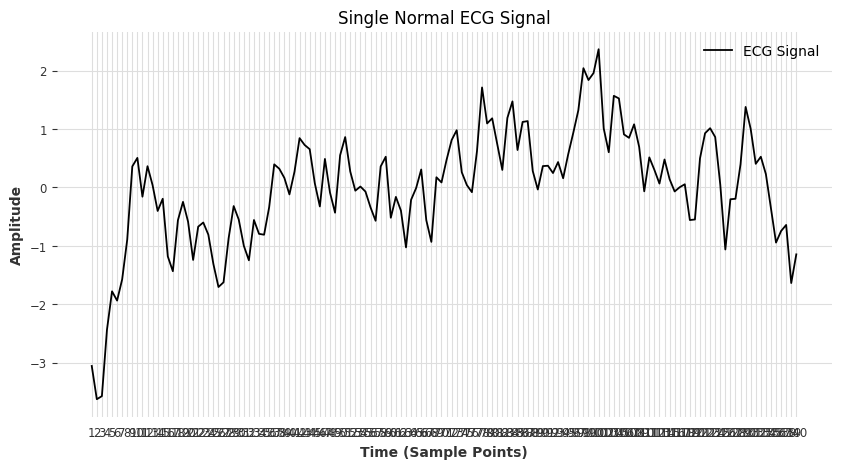

In [7]:
#%% Plot One Normal ECG Recording

selected_normal_signal = ecg_signals.iloc[random.randint(0, len(ecg_signals) - 1)]

plt.figure(figsize=(10, 5))
plt.plot(selected_normal_signal, label='ECG Signal')
plt.xlabel('Time (Sample Points)')
plt.ylabel('Amplitude')
plt.title('Single Normal ECG Signal')
plt.legend()
plt.show()

In [8]:
#%% Extract and Save Abnormal Data

abnormal_data = combined_data[combined_data.iloc[:, 0].isin([2.0, 3.0, 4.0, 5.0])]
abnormal_data.to_csv('D:/ECG5000/ecg5000_abnormal.csv', index=False)
abnormal_data = pd.read_csv('D:/ECG5000/ecg5000_abnormal.csv')


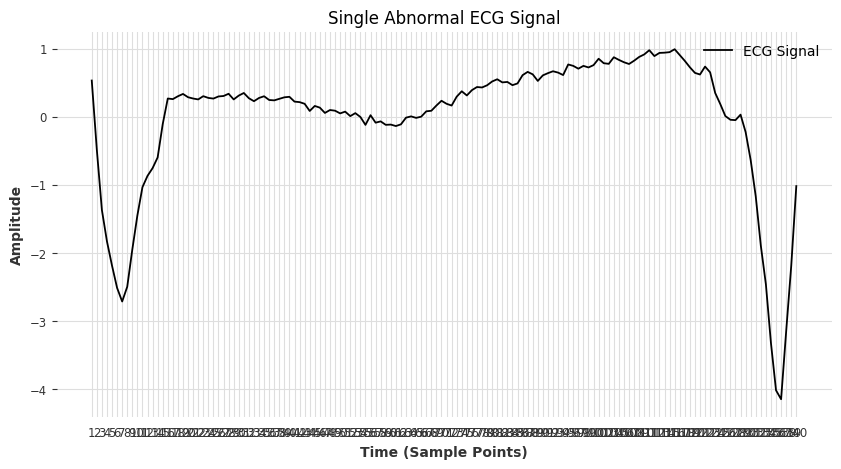

In [9]:
#%% Plot One Abnormal ECG Recording

ecg_signals = abnormal_data.iloc[:, 1:]
selected_abnormal_signal = ecg_signals.iloc[random.randint(0, len(ecg_signals) - 1)]

plt.figure(figsize=(10, 5))
plt.plot(selected_abnormal_signal, label='ECG Signal')
plt.xlabel('Time (Sample Points)')
plt.ylabel('Amplitude')
plt.title('Single Abnormal ECG Signal')
plt.legend()
plt.show()

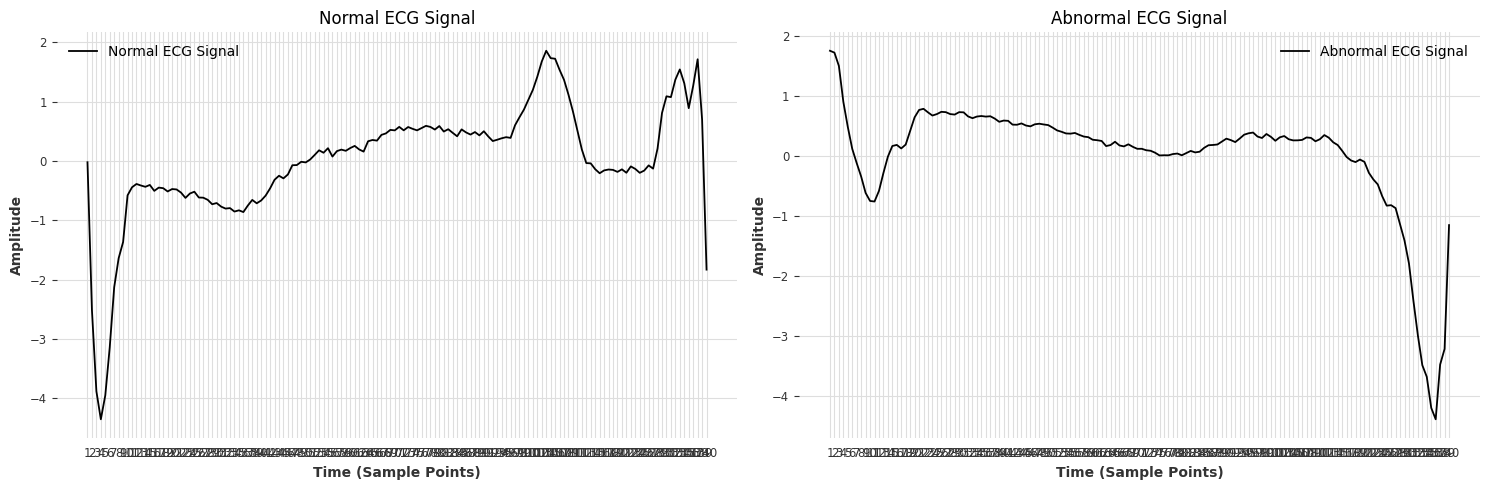

In [10]:
#%% Plot the selected ECG signals side by side (normal and abnormal)

# Select a specific ECG signal to plot
selected_normal_signal = normal_data.iloc[random.randint(0, len(normal_data) - 1), 1:]
selected_abnormal_signal = abnormal_data.iloc[random.randint(0, len(abnormal_data) - 1), 1:]

plt.figure(figsize=(15, 5))

# Plot normal ECG signal
plt.subplot(1, 2, 1)
plt.plot(selected_normal_signal, label='Normal ECG Signal')
plt.xlabel('Time (Sample Points)')
plt.ylabel('Amplitude')
plt.title('Normal ECG Signal')
plt.legend()

# Plot abnormal ECG signal
plt.subplot(1, 2, 2)
plt.plot(selected_abnormal_signal, label='Abnormal ECG Signal')
plt.xlabel('Time (Sample Points)')
plt.ylabel('Amplitude')
plt.title('Abnormal ECG Signal')
plt.legend()

plt.tight_layout()
plt.show()


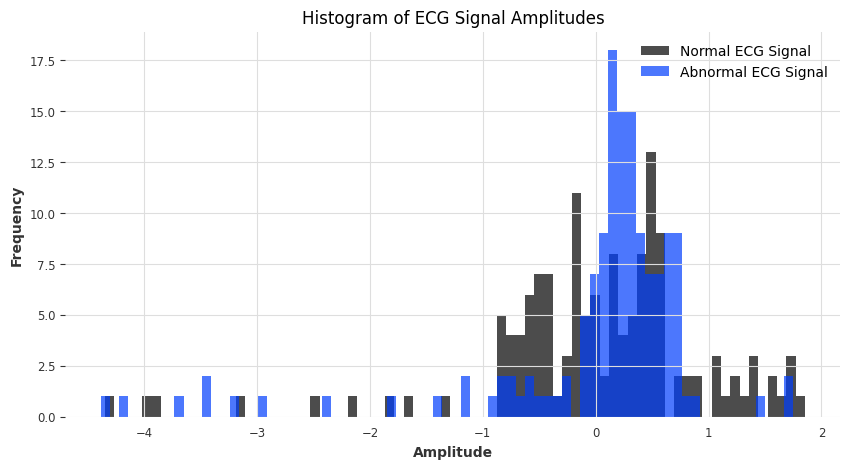

In [11]:
#%% Histogram of ECG Signal Amplitudes

plt.figure(figsize=(10, 5))
plt.hist(selected_normal_signal, bins=75, alpha=0.7, label='Normal ECG Signal')
plt.hist(selected_abnormal_signal, bins=75, alpha=0.7, label='Abnormal ECG Signal')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Histogram of ECG Signal Amplitudes')
plt.legend()
plt.show()


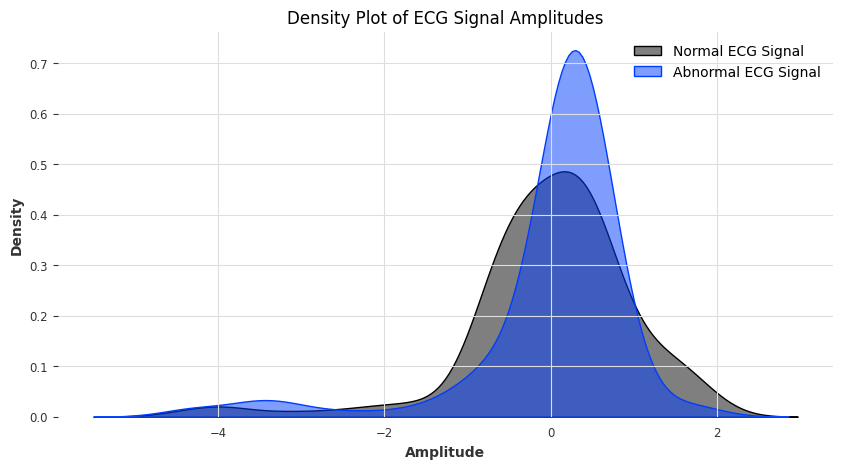

In [12]:
#%% Density Plot of ECG Signal Amplitudes

plt.figure(figsize=(10, 5))
sns.kdeplot(selected_normal_signal, label='Normal ECG Signal', fill=True, alpha=0.5)
sns.kdeplot(selected_abnormal_signal, label='Abnormal ECG Signal', fill=True, alpha=0.5)
plt.xlabel('Amplitude')
plt.ylabel('Density')
plt.title('Density Plot of ECG Signal Amplitudes')
plt.legend()
plt.show()

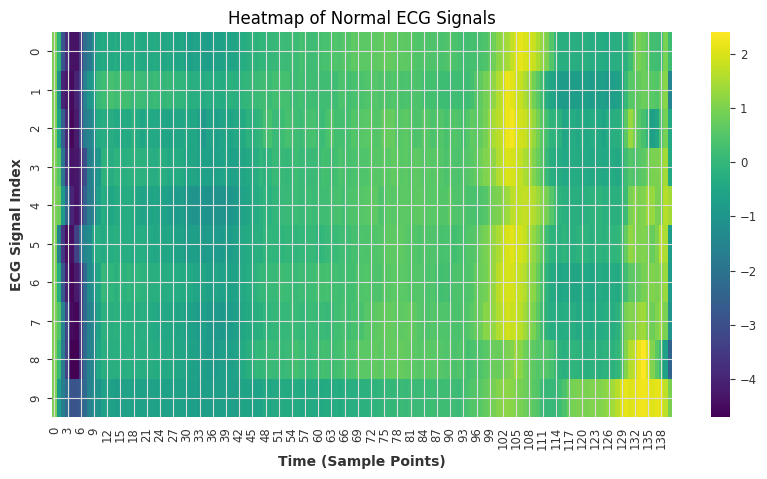

In [13]:
#%% Heatmap of Multiple ECG Signals

plt.figure(figsize=(10, 5))
sns.heatmap(normal_data.iloc[:10, :], cmap='viridis')
plt.xlabel('Time (Sample Points)')
plt.ylabel('ECG Signal Index')
plt.title('Heatmap of Normal ECG Signals')
plt.show()

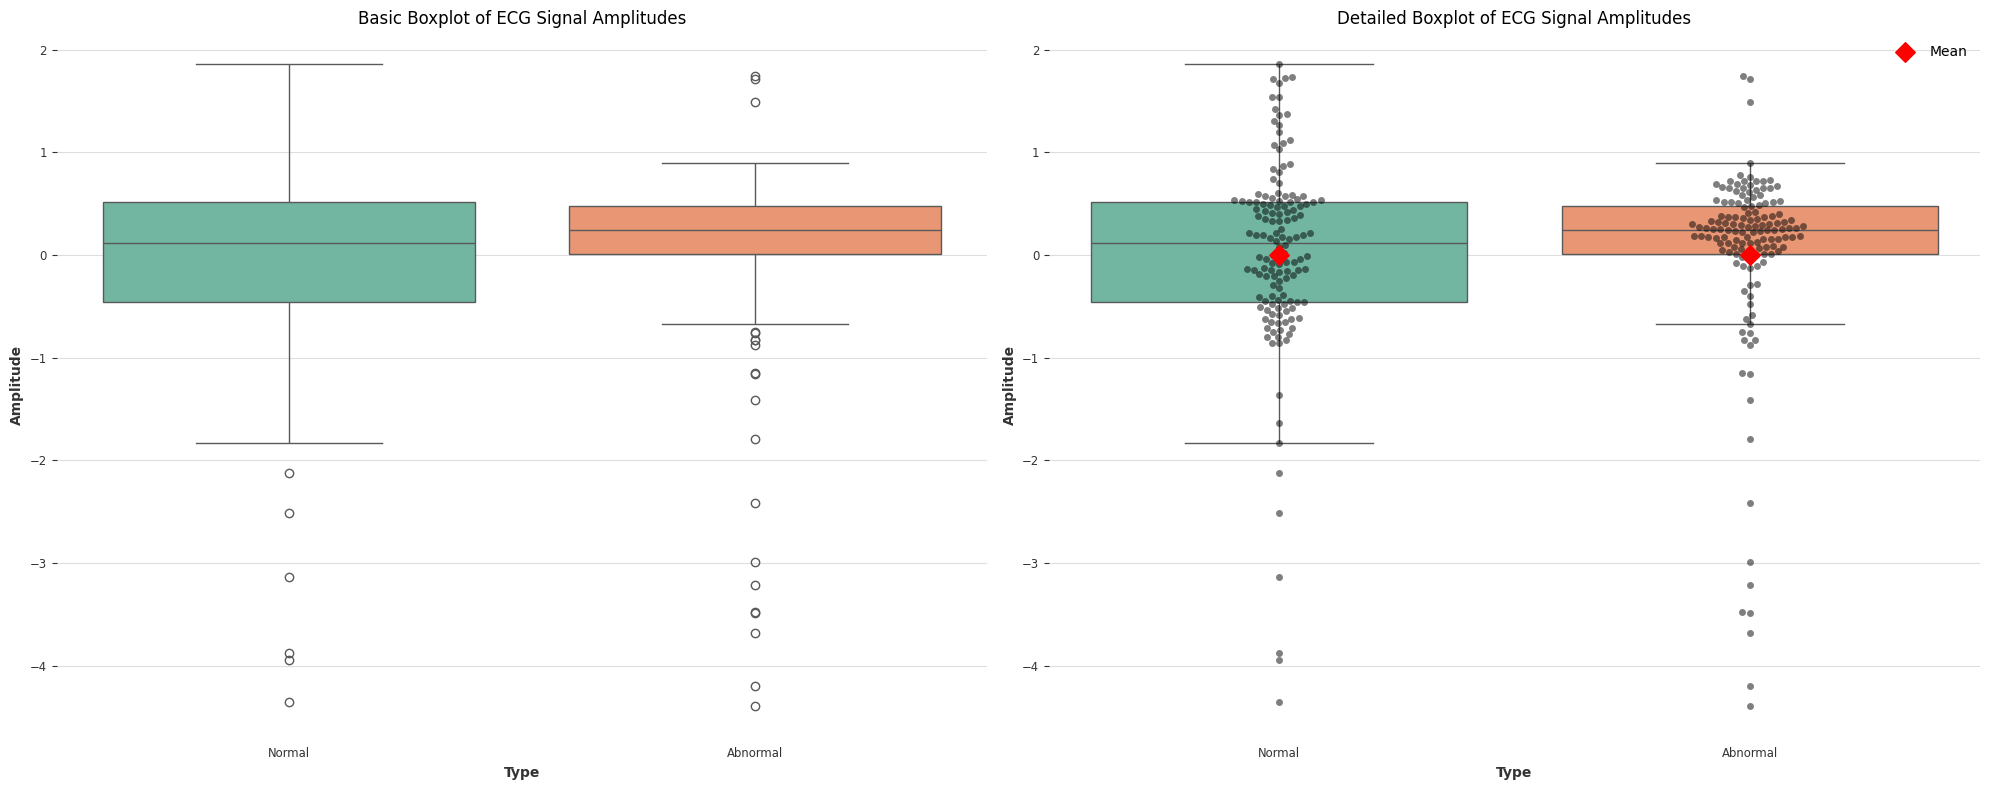

In [14]:
#%% Basic and Detailed Boxplot of ECG Signal Amplitudes

# Create a DataFrame for plotting
boxplot_data = pd.DataFrame({
    'Amplitude': pd.concat([selected_normal_signal, selected_abnormal_signal]),
    'Type': ['Normal'] * len(selected_normal_signal) + ['Abnormal'] * len(selected_abnormal_signal)
})

plt.figure(figsize=(20, 8))

# Basic Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='Type', y='Amplitude', data=boxplot_data, palette='Set2')
plt.title('Basic Boxplot of ECG Signal Amplitudes')

# Detailed Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x='Type', y='Amplitude', data=boxplot_data, palette='Set2', showfliers=False)
sns.swarmplot(x='Type', y='Amplitude', data=boxplot_data, color='k', alpha=0.5, dodge=True)

# Add mean markers
mean_values = boxplot_data.groupby('Type')['Amplitude'].mean()
for i, mean in enumerate(mean_values):
    plt.scatter(x=i, y=mean, color='red', marker='D', s=100, label='Mean' if i == 0 else "", zorder=10)

plt.title('Detailed Boxplot of ECG Signal Amplitudes')
plt.legend()

plt.tight_layout()
plt.show()

# Preprocessing on Normal Data

In [15]:
#%% Remove the label column

normal_data.drop(normal_data.columns[0], axis=1, inplace=True)
normal_data.head()

1         2         3         4         5         6         7  \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

          8         9        10  ...       131       132       133       134  \
0 -1.818286 -1.250522 -0.477492  ...  0.160348  0.792168  0.933541  0.796958   
1 -0.992258 -0.754680  0.042321  ...  0.560327  0.538356  0.656881  0.787490   
2 -1.490659 -1.183580 -0.394229  ...  1.284825  0.886073  0.531452  0.311377   
3 -1.671131 -1.333884 -0.965629  ...  0.491173  0.350816  0.499111  0.600345   
4 -1.783423 -1.594450 -0.753199  ...  0.966606  1.148884  0.958434  1.059025   

        135       136       137       138       139       140  
0  0.578621  0.257740  0.228077  0.123431  0.925286  0.193137  
1  0.724046  0.555784  0.476333  0.773820  1.119621 -1.436250  
2 -0.021919 -0.713683 -0.532197  0.321097  0.904227 -0.421797  
3  0.842069  0.952074  0.990133  1.086798  1.403011 -0.383564  
4  1.371682  1.277392  0.960304  0.971020  1.614392  1.421456  

[5 rows x 140 columns]

In [16]:
#%% Split data into train, valdidation, and test

# Split into training and remaining (test + validation)
train_data, temp_data = train_test_split(normal_data, test_size=0.3, random_state=42)

# Split the remaining data into test and validation
test_data, validation_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Print the shapes of the datasets
print(f"Training Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {validation_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Training Data Shape: (2043, 140)
Validation Data Shape: (438, 140)
Test Data Shape: (438, 140)


In [17]:
#%% Normalize the data using RobustScaler

# Initialize RobustScaler
scaler = RobustScaler()

# Fit on training data and transform train, validation, and test sets
train_features_scaled = scaler.fit_transform(train_data)
validation_features_scaled = scaler.transform(validation_data)
test_features_scaled = scaler.transform(test_data)

# Convert scaled features back to DataFrames if needed
train_data_scaled = pd.DataFrame(train_features_scaled, columns=train_data.columns)
validation_data_scaled = pd.DataFrame(validation_features_scaled, columns=validation_data.columns)
test_data_scaled = pd.DataFrame(test_features_scaled, columns=test_data.columns)

# Print the shapes of the scaled datasets
print(f"Scaled Training Data Shape: {train_data_scaled.shape}")
print(f"Scaled Validation Data Shape: {validation_data_scaled.shape}")
print(f"Scaled Test Data Shape: {test_data_scaled.shape}")


Scaled Training Data Shape: (2043, 140)
Scaled Validation Data Shape: (438, 140)
Scaled Test Data Shape: (438, 140)


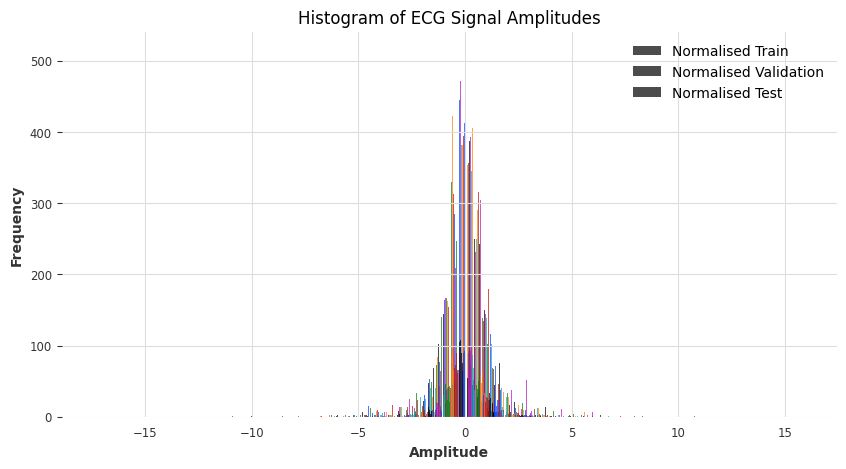

In [18]:
#%% Histogram of scaled data

plt.figure(figsize=(10, 5))
plt.hist(train_data_scaled, bins=75, alpha=0.7, label='Normalised Train')
plt.hist(validation_data_scaled, bins=75, alpha=0.7, label='Normalised Validation')
plt.hist(test_data_scaled, bins=75, alpha=0.7, label='Normalised Test')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Histogram of ECG Signal Amplitudes')
plt.legend()
plt.show()

In [19]:
#%% Remove index

train_data_scaled.reset_index(drop=True, inplace=True)
validation_data_scaled.reset_index(drop=True, inplace=True)
test_data_scaled.reset_index(drop=True, inplace=True)
train_data_scaled.head()
validation_data_scaled.head()
test_data_scaled.head()

1         2         3         4         5         6         7  \
0 -0.132394 -0.641296 -0.426380 -0.377511 -0.162521  0.780756  0.481302   
1  0.658419  1.343169  1.101458  1.522987 -0.091359 -0.666563 -0.691936   
2 -0.178278 -0.033876  0.243537 -0.090738 -0.510682 -0.155648  0.033961   
3  0.602227  1.465693  1.771358  2.115425  1.200210 -0.910575 -1.898675   
4  0.420857  0.352492  0.198599 -0.277100 -0.774639 -0.224593 -0.147538   

          8         9        10  ...       131       132       133       134  \
0  0.064879  0.935561  0.897901  ... -0.042536  0.537542  0.401006  0.234686   
1 -1.256640 -0.722822 -0.505430  ... -1.159002 -1.512846 -0.839990  0.172942   
2  0.695595 -0.033554 -0.123223  ... -0.333087  1.442914  1.794423  0.885432   
3 -3.691682 -0.880959 -1.424594  ... -0.621712  0.188786 -0.166474  0.106073   
4 -0.111258 -0.323437 -0.264717  ...  0.353095  0.010004  0.154042  0.156500   

        135       136       137       138       139       140  
0 -0.362604 -0.592130 -0.584513 -0.252685  0.100435 -0.922608  
1  0.137219  0.689427  0.593272  0.444617 -0.119738  0.785213  
2  0.269237 -0.426821 -1.288132 -1.834308 -1.485398 -0.196290  
3  0.011692 -0.204001 -0.687580 -1.372603 -0.972027 -0.147814  
4  0.197993  0.179637  0.181484  0.492402  0.604920  0.270792  

[5 rows x 140 columns]

In [20]:
#%% Printing infos
train_data_scaled.info()
validation_data_scaled.info()
test_data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Columns: 140 entries, 1 to 140
dtypes: float64(140)
memory usage: 2.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Columns: 140 entries, 1 to 140
dtypes: float64(140)
memory usage: 479.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Columns: 140 entries, 1 to 140
dtypes: float64(140)
memory usage: 479.2 KB


In [21]:
#%% Convert Datasets to TimeSeries
train_series = TimeSeries.from_dataframe(train_data_scaled)
validation_series = TimeSeries.from_dataframe(validation_data_scaled)
test_series = TimeSeries.from_dataframe(test_data_scaled)
train_series = train_series.astype(np.float32)
validation_series = validation_series.astype(np.float32)


In [22]:
#%% Displaying the first 5 rows of dataframes after adding TimeSeries

train_series.head(5)
validation_series.head(5)
test_series.head(5)

<TimeSeries (DataArray) (time: 5, component: 140, sample: 1)> Size: 6kB
array([[[-1.32393832e-01],
        [-6.41295763e-01],
        [-4.26379900e-01],
        [-3.77510995e-01],
        [-1.62520978e-01],
        [ 7.80756169e-01],
        [ 4.81302066e-01],
        [ 6.48785205e-02],
        [ 9.35561352e-01],
        [ 8.97900757e-01],
        [ 6.48413480e-01],
        [ 4.37062058e-01],
        [ 4.98988130e-01],
        [ 4.21544788e-01],
        [ 6.36175591e-01],
        [ 7.15150736e-01],
        [ 5.25784634e-01],
        [ 1.82345390e-01],
        [ 7.53757602e-02],
        [ 4.92000089e-02],
...
        [ 1.83541750e-01],
        [-4.54273931e-02],
        [ 2.91098239e-01],
        [ 2.26096272e-01],
        [ 1.85477690e-01],
        [ 2.89207752e-01],
        [ 2.22837492e-01],
        [ 1.94250308e-01],
        [ 3.10655231e-01],
        [ 4.53027146e-01],
        [ 3.53094981e-01],
        [ 1.00044010e-02],
        [ 1.54041764e-01],
        [ 1.56499515e-01],
        [ 1.97992906e-01],
        [ 1.79637329e-01],
        [ 1.81483628e-01],
        [ 4.92401627e-01],
        [ 6.04920043e-01],
        [ 2.70791815e-01]]])
Coordinates:
  * time       (time) int64 40B 0 1 2 3 4
  * component  (component) object 1kB '1' '2' '3' '4' ... '138' '139' '140'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# Model Architecture

In [78]:
class LossLoggingCallback(Callback):
    def __init__(self, log_file='D:/ECG5000/training_metrics.json'):
        self.log_file = log_file
        self.metrics = {"epochs": [], "train_loss": [], "val_loss": []}
        self.train_losses = []  # Initialize the list
        self.val_losses = []    # Initialize the list
        # Ensure the directory exists
        os.makedirs(os.path.dirname(self.log_file), exist_ok=True)

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss", None)
        if train_loss is not None:
            train_loss = train_loss.item()
            self.train_losses.append(train_loss)
            print(f"Train epoch end: recorded train loss {train_loss}")

    def on_val_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss", None)
        if val_loss is not None:
            val_loss = val_loss.item()
            self.val_losses.append(val_loss)
            print(f"Validation epoch end: recorded validation loss {val_loss}")

            # Append new metrics
            epoch = trainer.current_epoch  # Get current epoch
            self.metrics["epochs"].append(epoch)
            self.metrics["train_loss"].append(self.train_losses[-1] if self.train_losses else None)
            self.metrics["val_loss"].append(val_loss)

            # Save updated metrics
            try:
                with open(self.log_file, 'w') as f:
                    json.dump(self.metrics, f)
            except IOError as e:
                print(f"Error writing to file {self.log_file}: {e}")

# Define the model
ecg_model = TCNModel(
    input_chunk_length=50,
    output_chunk_length=30,
    kernel_size=3,
    num_filters=32,
    num_layers=3,
    dropout=0.2,
    optimizer_cls=Adam,
    optimizer_kwargs={"lr": 0.001},
    random_state=42
)

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor="val_loss",  # Metric to monitor
    patience=5,          # Number of epochs to wait for improvement
    mode="min"           # Mode should be 'min' for loss metrics
)

# Create the callback instances
loss_callback = LossLoggingCallback(log_file='D:/ECG5000/training_metrics.json')

# Initialize the trainer with callbacks
trainer = Trainer(
    callbacks=[early_stopping_callback, loss_callback],
    max_epochs=50,
    logger=True,
    enable_progress_bar=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Fitting model, evaluation

In [79]:
#%% Train the model
ecg_model.fit(train_series, val_series=validation_series, trainer=trainer)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | eval 
1 | train_criterion | MSELoss          | 0      | eval 
2 | val_criterion   | MSELoss          | 0      | eval 
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 48.6 K | train
-------------------------------------------------------------
48.6 K    Trainable params
0         Non-trainable params
48.6 K    Total params
0.194     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 62/62 [00:02<00:00, 28.57it/s, v_num=9, train_loss=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 62/62 [00:02<00:00, 28.23it/s, v_num=9, train_loss=0.884, val_loss=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 62/62 [00:02<00:00, 29.49it/s, v_num=9, train_loss=0.769, val_loss=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 62/62 [00:03<00:00, 18.04it/s, v_num=9, train_loss=0.692, val_loss=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 62/62 [00:02<00:00, 22.58it/s, v_num=9, train_loss=0.615, val_loss=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 62/62 [00:02<00:00, 26.00it/s, v_num=9, train_loss=0.587, val_loss=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 62/62 [00:02<00:00, 23.81it/s, v_num=9, train_loss=0.587, val_loss=1.110]


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=32, num_layers=3, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=50, output_chunk_length=30, optimizer_cls=<class 'torch.optim.adam.Adam'>, optimizer_kwargs={'lr': 0.001}, random_state=42)

In [83]:
def plot_val_loss(log_file='D:/ECG5000/training_metrics.json'):
    # Load metrics from the JSON file
    try:
        with open(log_file, 'r') as f:
            metrics = json.load(f)
    except IOError as e:
        print(f"Error reading the file {log_file}: {e}")
        return
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from the file {log_file}: {e}")
        return

    # Extract epochs and validation loss
    epochs = metrics.get("epochs", [])
    val_loss = metrics.get("val_loss", [])

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_loss, marker='o', linestyle='-', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs. Epochs')
    plt.grid(True)
    plt.xticks(range(min(epochs), max(epochs) + 1, 1))  # Adjust x-ticks if needed
    plt.show()

# Call the function to plot
plot_val_loss()

Error reading the file D:/ECG5000/training_metrics.json: [Errno 2] No such file or directory: 'D:/ECG5000/training_metrics.json'


In [26]:
#%% Save the model

# Define the path to save the model
model_save_path = 'D:/ECG5000/ecg_model.pth.tar'

# Save the model
ecg_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to D:/ECG5000/ecg_model.pth.tar


# Preprocessing Abnormal Data

In [27]:
#%% Preparing Abnormal data like Normal data

# Load abnormal data
abnormal_data = pd.read_csv('D:/ECG5000/ecg5000_abnormal.csv')

In [28]:
# Remove the label column if it exists
abnormal_data.drop(abnormal_data.columns[0], axis=1, inplace=True)
abnormal_data.head()

1         2         3         4         5         6         7  \
0 -0.032245 -0.545050 -0.822340 -1.605085 -1.805775 -2.008067 -2.233975   
1 -0.003377 -0.279265 -0.230519 -0.635978 -0.894795 -1.023105 -1.243738   
2  0.195989 -0.222258 -0.754773 -1.415614 -1.775851 -2.162326 -2.467492   
3  0.894867 -0.003822 -0.751052 -1.396543 -1.737838 -2.113020 -2.213210   
4  1.250060  0.760800  0.042925 -0.627974 -0.963454 -1.261335 -1.652440   

          8         9        10  ...       131       132       133       134  \
0 -2.191458 -2.058071 -1.880849  ... -0.906425 -1.621376 -2.329090 -3.049894   
1 -1.458372 -1.677896 -1.784530  ... -2.155969 -2.640508 -3.218384 -3.651630   
2 -2.331384 -1.993476 -1.611709  ... -0.162438 -0.935030 -1.654340 -2.434240   
3 -2.203347 -2.024191 -1.591458  ... -0.899746 -1.441516 -1.861612 -2.321381   
4 -1.888433 -1.935217 -1.808429  ... -0.695282 -0.979223 -1.353969 -1.952051   

        135       136       137       138       139       140  
0 -3.620413 -4.210482 -4.043785 -3.051813 -2.806866 -0.879666  
1 -3.881198 -3.924672 -3.164390 -2.228373 -1.837544 -0.378489  
2 -3.472170 -4.280780 -4.629438 -3.794192 -2.851468 -1.743521  
3 -2.884877 -3.530246 -4.412515 -3.903331 -3.567106 -1.536338  
4 -2.640386 -3.000281 -3.812490 -3.973360 -5.221946 -3.661793  

[5 rows x 140 columns]

In [29]:
# Ensure that the abnormal data has the same columns as the training data
abnormal_data.columns = abnormal_data.columns
print(abnormal_data.columns)
print(normal_data.columns)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '131', '132', '133', '134', '135', '136', '137', '138', '139', '140'],
      dtype='object', length=140)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '131', '132', '133', '134', '135', '136', '137', '138', '139', '140'],
      dtype='object', length=140)


In [30]:
# Apply the fitted RobustScaler to the abnormal data
abnormal_features_scaled = scaler.transform(abnormal_data)

# Convert scaled features back to DataFrame
abnormal_data_scaled = pd.DataFrame(abnormal_features_scaled, columns=abnormal_data.columns)

# Print the shape of the scaled abnormal dataset
print(f"Scaled Abnormal Data Shape: {abnormal_data_scaled.shape}")

Scaled Abnormal Data Shape: (2081, 140)


In [31]:
# Remove index
abnormal_data_scaled.reset_index(drop=True, inplace=True)
abnormal_data_scaled.head()

1         2         3         4         5         6         7  \
0  0.280711  1.060130  2.132341  3.459909  3.781873  1.423159 -0.035670   
1  0.298148  1.209665  2.605845  4.778135  5.410301  2.483503  0.995163   
2  0.418567  1.241739  2.186400  3.717636  3.835364  1.257094 -0.278761   
3  0.840696  1.364635  2.189377  3.743577  3.903315  1.310173 -0.014054   
4  1.055236  1.794826  2.824622  4.789023  5.287570  2.227041  0.569705   

          8         9        10  ...       131       132       133       134  \
0 -1.426496 -1.285618 -1.907968  ... -2.558674 -4.835783 -6.120780 -5.964503   
1  0.434233 -0.654032 -1.761500  ... -4.312239 -6.672402 -7.699064 -6.821567   
2 -1.781659 -1.178306 -1.498699  ... -1.514591 -3.598891 -4.923258 -5.087616   
3 -1.456673 -1.229332 -1.467905  ... -2.549302 -4.511651 -5.291116 -4.926869   
4 -0.657354 -1.081520 -1.797843  ... -2.262365 -3.678533 -4.390171 -4.400826   

        135       136       137       138       139       140  
0 -5.023823 -4.511429 -3.970236 -2.808913 -2.486042 -0.247133  
1 -5.303645 -4.255406 -3.239557 -2.192909 -1.811666  0.041808  
2 -4.864757 -4.574401 -4.456848 -3.364277 -2.517072 -0.745165  
3 -4.234591 -3.902086 -4.276609 -3.445922 -3.014955 -0.625719  
4 -3.972252 -3.427353 -3.778056 -3.498310 -4.166258 -1.851094  

[5 rows x 140 columns]

In [32]:
# Convert abnormal data to TimeSeries format
abnormal_series = TimeSeries.from_dataframe(abnormal_data_scaled)

In [33]:
# Display first 5 rows of the TimeSeries
abnormal_series.head(5)

<TimeSeries (DataArray) (time: 5, component: 140, sample: 1)> Size: 6kB
array([[[ 2.80711500e-01],
        [ 1.06012996e+00],
        [ 2.13234081e+00],
        [ 3.45990858e+00],
        [ 3.78187293e+00],
        [ 1.42315950e+00],
        [-3.56703650e-02],
        [-1.42649568e+00],
        [-1.28561783e+00],
        [-1.90796762e+00],
        [-3.63060213e+00],
        [-2.45846632e+00],
        [-1.07198132e+00],
        [-4.24191060e-01],
        [-1.32828889e-01],
        [-3.19201497e-03],
        [ 4.04897320e-01],
        [ 1.39383738e+00],
        [ 2.13487234e+00],
        [ 2.55927190e+00],
...
        [ 2.16641689e+00],
        [ 1.85587820e+00],
        [ 1.74866990e+00],
        [ 1.42159083e+00],
        [ 1.11737886e+00],
        [ 5.28767836e-01],
        [-1.62017904e-02],
        [-6.42012218e-01],
        [-1.47815558e+00],
        [-1.52332626e+00],
        [-2.26236462e+00],
        [-3.67853297e+00],
        [-4.39017120e+00],
        [-4.40082559e+00],
        [-3.97225162e+00],
        [-3.42735282e+00],
        [-3.77805586e+00],
        [-3.49831043e+00],
        [-4.16625816e+00],
        [-1.85109434e+00]]])
Coordinates:
  * time       (time) int64 40B 0 1 2 3 4
  * component  (component) object 1kB '1' '2' '3' '4' ... '138' '139' '140'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# Load Model

In [34]:
#%% Load the saved model

# Define the path to the saved model
model_save_path = 'D:/ECG5000/ecg_model.pth.tar'

# Load the model
loaded_ecg_model = TCNModel.load(model_save_path)

print("Model loaded successfully")

Model loaded successfully


# Fitting on Anomalous Data

In [64]:
# Obtain predictions on Abnormal Data
abnormal_series = abnormal_series.astype(np.float32)  # Ensure data is float32
abnormal_reconstructed = ecg_model.predict(n=len(abnormal_series), series=abnormal_series)
reconstruction_errors = (abnormal_series.pd_dataframe() - abnormal_reconstructed.pd_dataframe()).abs()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


In [65]:
# Determine the Anomaly Threshold
threshold = reconstruction_errors.mean() + 3 * reconstruction_errors.std()
anomalies = reconstruction_errors > threshold

Number of components is larger than 10 (140). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 10 (140). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

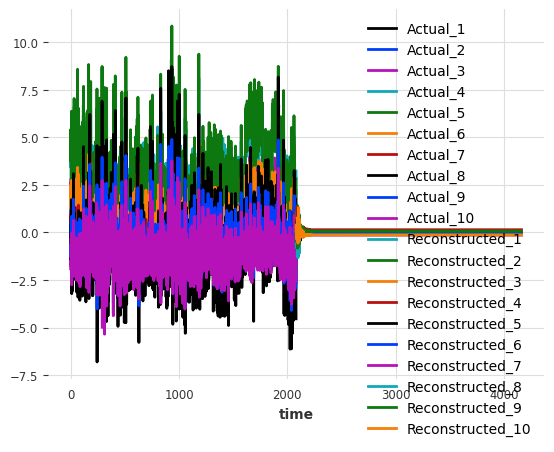

In [66]:
abnormal_series.plot(label='Actual')
abnormal_reconstructed.plot(label='Reconstructed')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.legend()
plt.show()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


Number of components is larger than 10 (140). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 10 (140). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

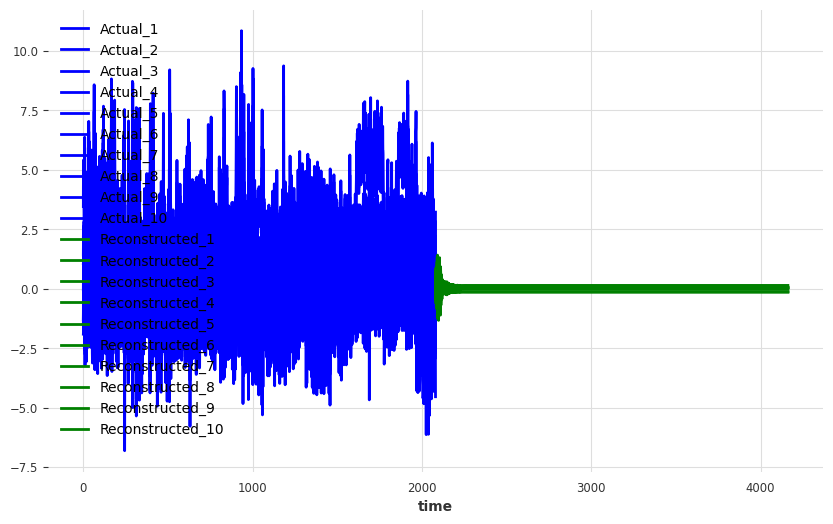

In [86]:
# Make predictions
abnormal_reconstructed = ecg_model.predict(n=len(abnormal_series), series=abnormal_series)

# Calculate reconstruction errors
reconstruction_errors = (abnormal_series.pd_dataframe() - abnormal_reconstructed.pd_dataframe()).abs()

# Set anomaly detection threshold
threshold = reconstruction_errors.mean() + 3 * reconstruction_errors.std()

# Identify anomalies
anomalies = reconstruction_errors > threshold

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
abnormal_series.plot(label='Actual', color='blue')
abnormal_reconstructed.plot(label='Reconstructed', color='green')
plt.scatter(anomalies.index[anomalies.values], abnormal_series[anomalies], color='red', label='Anomalies')
plt.axhline(y=threshold.values, color='r', linestyle='--', label='Anomaly Threshold')
plt.legend()
plt.show()


# Fitting on Anomalous Data (take 2)